In [3]:
import mxnet as mx

In [4]:
# define the device type that the computations should be executed on
# can be cpu or gpu
data_ctx = mx.cpu()
model_ctx = mx.cpu()

# 1. Linear Regression with Neural Networks

We will consider the linear model : 
$$Y_i = X_{i1}w_1 + X_{i2}w_2 + \epsilon_i$$ for i = 1,2,...,n. This can be expressed :
$$ Y = Xw + b + \epsilon,  \text{  where  } \epsilon \sim N(0, 0.01)$$

The inputs will be sampled from a standard normal distribution and will be independent. The target variable will be computed with: $$ y[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise, \text{  with  } noise \sim N(0, 0.01) $$

In [3]:
num_inputs = 2
num_outputs = 1
num_samples = 1000

# determine predictor variable 
X = mx.nd.random.normal(shape = (num_samples, num_inputs), ctx = data_ctx)

# determine noise
noise = mx.nd.random.normal(loc = 0, scale = 0.1, shape = (num_samples, ), ctx = data_ctx)  

# determine target varaible
y = 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2 + noise

## 1.1 Plot the correspondence between the predictor and target

Text(0.5, 1.0, 'Dependence on the second variable')

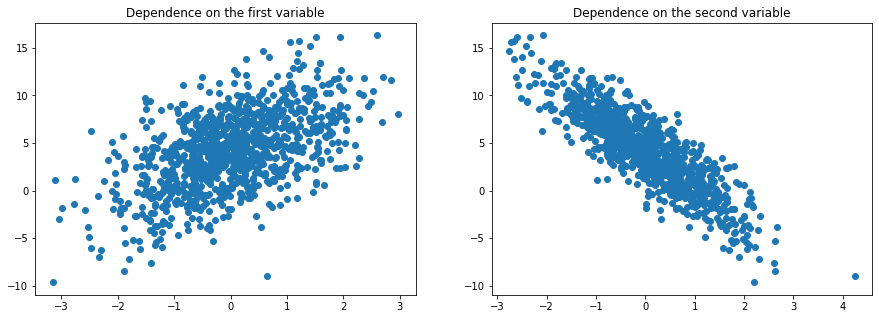

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize = (15,5))
axs[0].scatter(X[:, 0].asnumpy(), y.asnumpy())
axs[0].set_title("Dependence on the first variable")
axs[1].scatter(X[:, 1].asnumpy(), y.asnumpy())
axs[1].set_title("Dependence on the second variable")

## 1.2. Batches


We will employ the class **DataLoader** that will automatically grab random batches from the data. As a first argument, this takes an **ArrayDataset**. In turn, this will take X and y as arguments (they can have different dimensions as long as their dimension along the first axis is the same).

In [5]:
from mxnet import gluon

D:\Python_install\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
data = gluon.data.ArrayDataset(X, y)

In [7]:
batch_size = 4

In [8]:
train_data = gluon.data.DataLoader(data, batch_size = batch_size, shuffle = True)

The **DataLoader** takes 3 arguments: 

<ul>
    <li> data : an ArrayDataset created from X and y </li>
    <li> batch_size : how many sample points will be grabbed at a time </li>
    <li> shuffle : whether or not to shuffle the data between iterations through the dataset </li>
</ul>

Fortunately, the object returned by DataLoader can be iterated over. That way, the batches can be grabbed easily.

In [9]:
# grab mini-batches of data
# Method 1 
for data, label in train_data:
    #print(data)
    #print(label)
    pass
    
# Method 2 
for i, (data, label) in enumerate(train_data):
    pass
print(i+1)

250


As expected, there are 250 of batches, each with 4 sample points.

# 1.3 Model Parameters

The process of identifying optimal parameters is relatively different from the classical linear regression. Instead solving normal eqations, we will give an arbitrary value to our parameters (ie. $ w_1, w_2, b $). These are usually drawn from a normal distribution. Then we will atempt some sort of optimization which will determine the values of parameters to move towards the optimal ones. This is done by minimizing a **loss function** with respect to our parameters. For this purpose, we will take the gradient of the loss function with respect to the parameters and move to the direction that gives the smallest gradient.

In [10]:
# initialise parameters
w = mx.nd.random.normal(shape = (num_inputs, num_outputs), ctx = model_ctx)
b = mx.nd.random.normal(shape = (num_outputs), ctx = model_ctx)

# store initial values
params = [w, b]

In [11]:
# allocate memory for gradient
# after that grad is initialised to 0
for parameter in params:
    parameter.attach_grad()

## 1.4 Define that model

The following function will compute the output of the model following the linear relationship given at the beginning : 

In [12]:
def model(X):
    return mx.nd.dot(X, w) + b

Then we need a function that will tell us how well our model is performing. This is the loss function, and in this case it will be the mean squared error. This takes two arguments : the predicted value of the label and the actual label.

In [13]:
def square_loss(yhat, y):
    return mx.nd.mean((yhat - y) ** 2)

We now need an optimizer : a function that tells us in which direction to update the parameters so that the loss function is minimized.  We will use **Stochastic Gradient Descent**. That is, we will use one batch at each step and move slightly in the direction that diminish the loss. The size of the step is given by the *learning rate*.

In [14]:
def SGD(params, lr):
    for parameter in params:
        parameter[:] = parameter - lr * parameter.grad

## 1.5 Run the model

In [15]:
# no. of times to go through all the data
epochs = 10

# learning rate 
lr = 0.0001

# number of batches
num_batches = num_samples/batch_size

In [16]:
# loop over all data *epochs* times
for e in range(epochs):
    
    # initialise total loss
    cumulative_loss = 0
    
    # grab each batch 
    for i, (data, label) in enumerate(train_data):
        
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        
        with mx.autograd.record():
            output = model(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, lr)
        cumulative_loss += loss.asscalar()
    print(cumulative_loss/num_batches)

14.58870717906952
13.204577239990234
11.95211122429371
10.818618628501891
9.792670095860958
8.864223634243011
8.023855078935624
7.263439766168594
6.5750209040641785
5.952056400060654


In [17]:
# compute predictions
yhat = model(X)

D:\Python_install\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


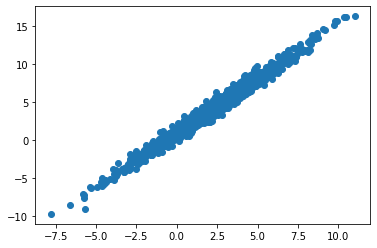

In [30]:
# plot predictions vs reality
plt.scatter(yhat.asnumpy(), y.asnumpy())

# 2. Linear Regression with gluon

In [32]:
# import necessary modules
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon

# set the context 
model_ctx = mx.cpu()
data_ctx = mx.cpu()

The dataset that we will use for this illustration is the same as in Part 1, so that we have *train_data* already prepared.
We can use the pre-implemented Dense Layer to represent our linear model. Two parameters need to be indicated (at least) :

<ul>
    <li> <b> units </b> : int, dimensionality of the output </li>
    <li> <b> in_units </b>. : int, dimensionality of the input </li>
</ul>

In [35]:
# one fully connected layer is equivalent to a linear model
net = gluon.nn.Dense(units = 1, in_units=2)

This model has exactely the same parameters as the previous one : 2 weights and a bias. One difference, though, is that these parameters are instances of **Parameter** class instead of **nd arrays**.

In [44]:
print(net.weight)
print(net.bias)

Parameter dense2_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)
Parameter dense2_bias (shape=(1,), dtype=<class 'numpy.float32'>)


Before feeding the data to the network, we need to initialise the parameters. Otherwise, the model would not know which values to optimise.

In [52]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

The initialize method of a **ParameterDict** will take two arguments :
<ul>
    <li>the initial value, which can be easy given using <b> mx.init </b> module </li>
    <li>a context where the parameters will live </li>
</ul>

What happens is known as **deferred initialization**: the parameters are not initilized until some data is passed to the model. That is, they are not initialized until actually needed. To access the value of a parameter, we can use **net.weight.data()**.

In [60]:
# pass some data through the network
# this is to initialize parameters
example_data = nd.array([[4,7]])
net(example_data)


[[1.0296844]]
<NDArray 1x1 @cpu(0)>

In [62]:
# as expected, parameters now have numerical values
print(net.weight.data())
print(net.bias.data())


[[ 0.5380863  -0.16038011]]
<NDArray 1x2 @cpu(0)>

[0.]
<NDArray 1 @cpu(0)>


The loss function can also be instantiated instead of built from scratch. Note that **L2 Loss** referes to the sum of the squared errors. On the other hand, **L1 Loss** refers to the sum of the absolute values of errors. 

In [71]:
square_loss = gluon.loss.L2Loss()

Again, instead of building a SGD function from the scratch, we can instantiate a **Trainer**. The first argument that needs to be passed is a dictionary of parameters.

In [72]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})

We will now go through the learning procedure.